In [2]:
import sys
sys.path.append('/Users/frama/Documents/EPITECH/ZOIDBERG2.0/src/')

# Modélisation avec SVM et PCA.

Les étapes incluent :
1. Chargement des données
2. Prétraitement des données
3. Application de PCA
4. Entraînement des modèles SVM
5. Évaluation et comparaison des résultats


In [3]:
# Importation des bibliothèques nécessaires 
# les bibliothèques pour le traitement des images, la manipulation des données, les algorithmes d'apprentissage automatique, et la visualisation
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from config  import PATH_PERSO_TEST_NEW, PATH_PERSO_VALID_NEW, PATH_PERSO_TRAIN_NEW
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

In [4]:
# Définition des datasets
dataset_train = PATH_PERSO_TRAIN_NEW
validation_dir = PATH_PERSO_VALID_NEW
testing_dir = PATH_PERSO_TEST_NEW

In [5]:
# Paramètrage des images
IMG_SIZE = 100 
LABELS = ['NORMAL', 'PNEUMONIA_B', 'PNEUMONIA_V']

# Fonction pour charger et prétraiter les données
# Cette fonction lit les images, les convertit en niveaux de gris, les redimensionne, et les stocke dans une liste avec leurs labels correspondants.
def load_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            if img.endswith(('jpg', 'jpeg', 'png')):
                try:
                    img_path = os.path.join(path, img)
                    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img_arr is None:
                        continue
                    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
    return np.array(data, dtype=object)

In [6]:
# Chargement des datasets train, validation et test
train_data = load_data(dataset_train)
val_data = load_data(validation_dir)
test_data = load_data(testing_dir)

In [7]:
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (4098, 2)
Testing data shape: (881, 2)
Validation data shape: (877, 2)


In [8]:
# Séparation des images et des labels
import numpy as np
def get_img_labels(data):
    x = []
    y = []
    for feature, label in data:
        x.append(feature)
        y.append(label)
    x = np.array(x, dtype=np.float32) / 255.0  # Utilisation de float32 pour réduire l'utilisation de la mémoire
    x = x.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = np.array(y)
    return x, y

x_train, y_train = get_img_labels(train_data)
x_val, y_val = get_img_labels(val_data)
x_test, y_test = get_img_labels(test_data)

In [9]:
# Normaliser le pixel avec standardScaler
# Les valeurs des pixels sont normalisées pour améliorer les performances du modèle.
scaler = StandardScaler()
pca = PCA(n_components=200)  # Reduced number of components

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

x_train = scaler.fit_transform(x_train_flat)
x_val = scaler.transform(x_val_flat)
x_test = scaler.transform(x_test_flat)

x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

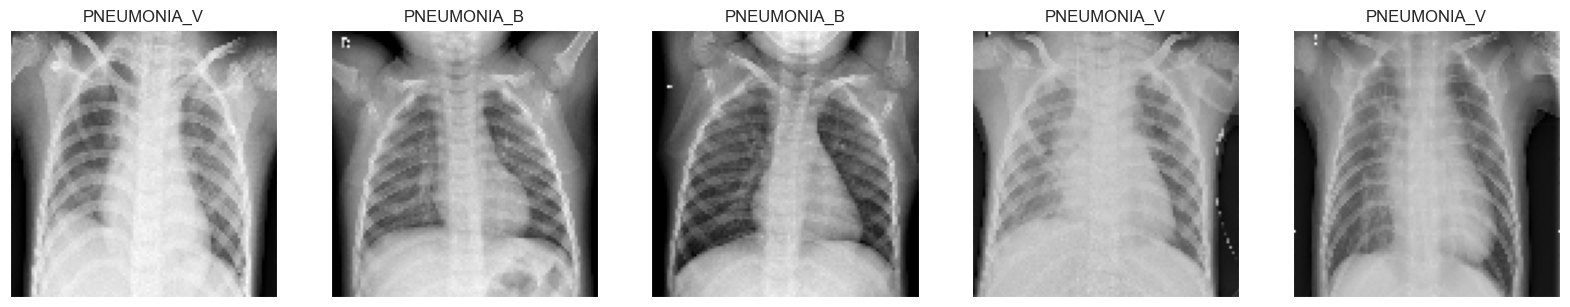

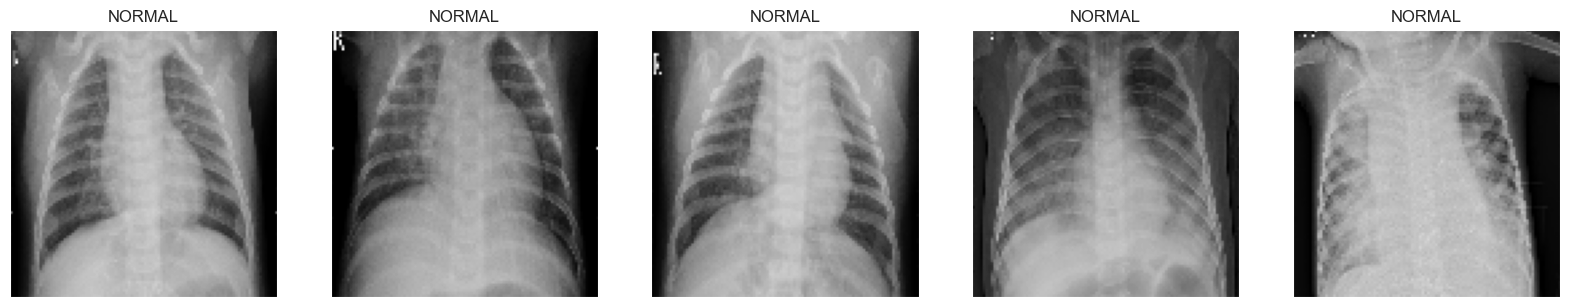

In [21]:
import random
# Labels des images
labels = ['PNEUMONIA_B', 'PNEUMONIA_V', 'NORMAL']

# Fonction pour visualiser quelques images
def visualize_images(data, labels, num_images=5):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i][0], cmap='gray')
        plt.title(labels[data[i][1]])
    plt.show()

# Filtrer les cas de pneumonie bactérienne et virale
train_data_pneumonia_b = [item for item in train_data if item[1] == labels.index('PNEUMONIA_B')]
train_data_pneumonia_v = [item for item in train_data if item[1] == labels.index('PNEUMONIA_V')]
train_data_pneumonia = train_data_pneumonia_b + train_data_pneumonia_v

# Mélanger les cas de pneumonie pour une visualisation variée
random.shuffle(train_data_pneumonia)

# Filtrer les cas non malades
train_data_normal = [item for item in train_data if item[1] == labels.index('NORMAL')]

# Les cas de pneumonie (bactérienne et virale)
visualize_images(train_data_pneumonia, labels, num_images=min(5, len(train_data_pneumonia)))

# Les cas non malades
visualize_images(train_data_normal, labels, num_images=min(5, len(train_data_normal)))


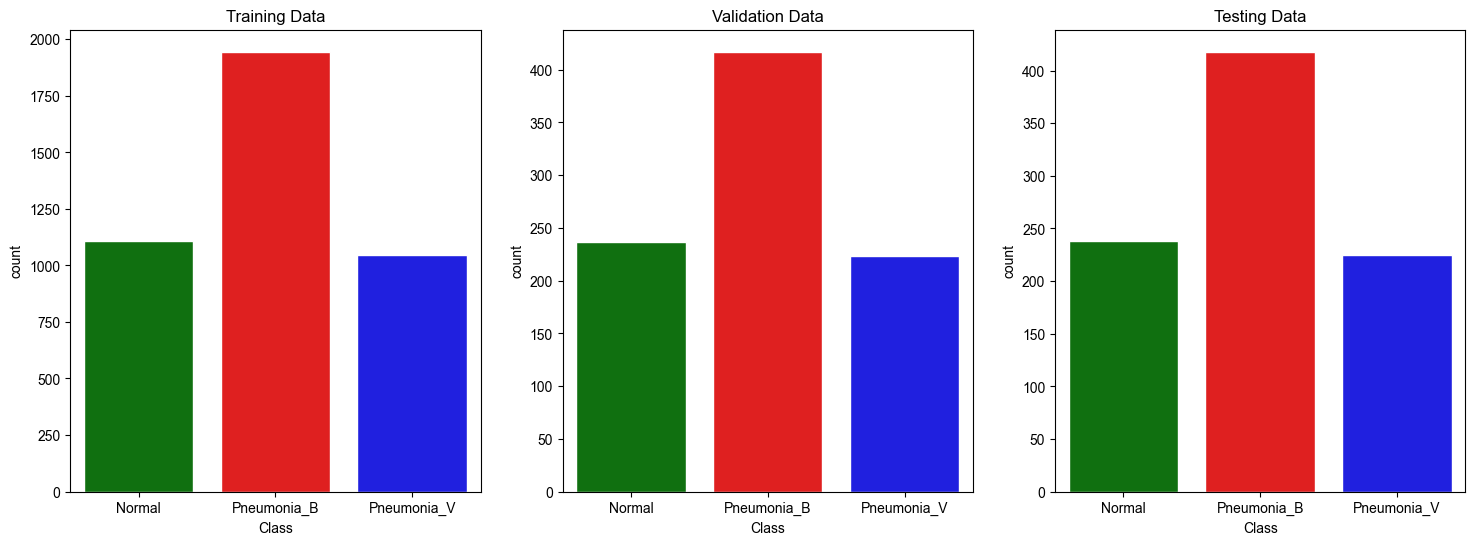

Training Data:
Nombre d'images normales : 1108
Nombre d'images de pneumonie bactérienne : 1945
Nombre d'images de pneumonie virale : 1045
Validation Data:
Nombre d'images normales : 237
Nombre d'images de pneumonie bactérienne : 417
Nombre d'images de pneumonie virale : 223
Testing Data:
Nombre d'images normales : 238
Nombre d'images de pneumonie bactérienne : 418
Nombre d'images de pneumonie virale : 225


In [11]:
def datasGraph(data, title):
    l = []
    for i in data:
        if i[1] == 1:
            l.append("Pneumonia_B")
        elif i[1] == 2:
            l.append("Pneumonia_V")
        else:
            l.append("Normal")

    sns.set_style('darkgrid')

    palette = {
        "Pneumonia_B": "red",
        "Pneumonia_V": "blue",
        "Normal": "green"
    }

    # Comptage des étiquettes dans le dataset
    count_normal = sum(1 for i in data if i[1] == 0)
    count_pneumonia_b = sum(1 for i in data if i[1] == 1)
    count_pneumonia_v = sum(1 for i in data if i[1] == 2)

    print(f"Nombre d'images normales : {count_normal}")
    print(f"Nombre d'images de pneumonie bactérienne : {count_pneumonia_b}")
    print(f"Nombre d'images de pneumonie virale : {count_pneumonia_v}")

# Création de sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Préparation des données pour les graphiques
def datasGraph_subplot(data, ax, title):
    l = []
    for i in data:
        if i[1] == 1:
            l.append("Pneumonia_B")
        elif i[1] == 2:
            l.append("Pneumonia_V")
        else:
            l.append("Normal")

    sns.set_style('darkgrid')

    palette = {
        "Pneumonia_B": "red",
        "Pneumonia_V": "blue",
        "Normal": "green"
    }

    # DataFrame for seaborn
    df = pd.DataFrame(l, columns=['Class'])

    # count plot
    sns.countplot(x='Class', data=df, palette=palette, hue='Class', ax=ax)
    ax.set_title(title)

# Affichage des graphiques dans les sous-graphiques
datasGraph_subplot(train_data, axes[0], "Training Data")
datasGraph_subplot(val_data, axes[1], "Validation Data")
datasGraph_subplot(test_data, axes[2], "Testing Data")

plt.show()

# Affichage des statistiques de comptage
print("Training Data:")
datasGraph(train_data, "Training Data")

print("Validation Data:")
datasGraph(val_data, "Validation Data")

print("Testing Data:")
datasGraph(test_data, "Testing Data")

In [12]:
from sklearn.metrics import auc, f1_score


def train_evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, labels):
    try:
        # Entrainement du modèle
        model.fit(x_train, y_train)
        print("Model training completed successfully.\n")

        # Evaluation du modèle
        y_pred_test = model.predict(x_test)
        y_pred_val = model.predict(x_val)
        
        print("Validation Classification Report:\n", classification_report(y_val, y_pred_val, target_names=labels))
        print("Test Classification Report:\n", classification_report(y_test, y_pred_test, target_names=labels))
        
        f1 = f1_score(y_test, y_pred_test, average='weighted')
        print(f'F1 Score: {f1:.2f}')

        # Plot ROC curve
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(x_test)
            fpr = {}
            tpr = {}
            roc_auc = {}
            
            for i in range(len(labels)):
                fpr[i], tpr[i], _ = roc_curve(y_test, y_proba[:, i], pos_label=i)
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.figure()
            for i, color in zip(range(len(labels)), ['blue', 'red', 'green']):
                plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

        # Confusion matrix pour les données de test
        cm = confusion_matrix(y_test, y_pred_test)
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
        plt.title('Confusion Matrix - Test Data')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return model

    except Exception as e:
        print(f"An error occurred: {e}")

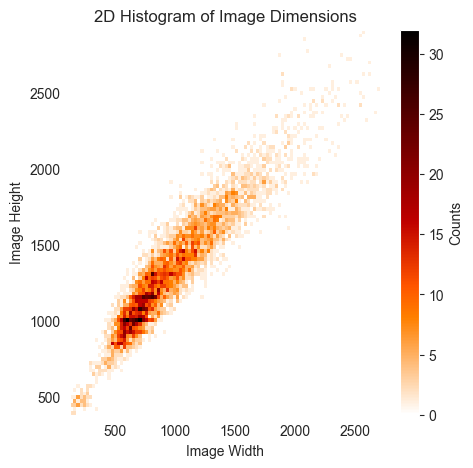

In [13]:
# La répartition des tailles de chaque image avec hist2d

# Vérification d'une image
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))

# Initialiser histogram data structure
hist_data = {
    'x': [],
    'y': [],
    'train': {
        'x': [],
        'y': []
    },
    'test': {
        'x': [],
        'y': []
    },
    'val': {
        'x': [],
        'y': []
    }
}

# Function to collect histogram data
def collect_hist2d_data(path, category):
    filelist = [file for file in os.listdir(path) if is_image_file(file)]
    
    if len(filelist) == 0:
        raise ValueError(f"No image files found in the directory {path}.")
    
    for x in filelist:
        img_path = os.path.join(path, x)
        try:
            img = plt.imread(img_path)
            shape = img.shape
            
            hist_data['x'].append(shape[0])
            hist_data['y'].append(shape[1])
            
            hist_data[category]['x'].append(shape[0])
            hist_data[category]['y'].append(shape[1])
            
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue

dir_paths = {
    "train_normal": os.path.join(dataset_train, 'NORMAL'),
    "train_pneumonia_b": os.path.join(dataset_train, 'PNEUMONIA_B'),
    "train_pneumonia_v": os.path.join(dataset_train, 'PNEUMONIA_V'),
    "val_normal": os.path.join(validation_dir, 'NORMAL'),
    "val_pneumonia_b": os.path.join(validation_dir, 'PNEUMONIA_B'),
    "val_pneumonia_v": os.path.join(validation_dir, 'PNEUMONIA_V'),
    "test_normal": os.path.join(testing_dir, 'NORMAL'),
    "test_pneumonia_b": os.path.join(testing_dir, 'PNEUMONIA_B'),
    "test_pneumonia_v": os.path.join(testing_dir, 'PNEUMONIA_V')
}

# Collect data
for key, path in dir_paths.items():
    category = key.split('_')[0]
    collect_hist2d_data(path, category)

# Plotting the 2D histogram for image dimensions
plt.figure(figsize=(5, 5))
plt.hist2d(hist_data['x'], hist_data['y'], bins=100, cmap=plt.cm.gist_heat_r)
plt.colorbar(label='Counts')
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('2D Histogram of Image Dimensions')
plt.show()

In [14]:
# Optimisation et évaluation des modèles
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC(kernel='rbf')
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', n_iter=10, n_jobs=-1)
random_search.fit(x_train_pca, y_train)
print(random_search.best_params_)

# Train the final model with the best parameters
final_model = SVC(kernel='rbf', C=random_search.best_params_['C'], gamma=random_search.best_params_['gamma'])
final_model.fit(x_train_pca, y_train)



{'gamma': 0.0001, 'C': 0.1}


SVC(C=0.1, gamma=0.0001)

Validation Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.90      0.85      0.88       237
 PNEUMONIA_V       0.73      0.90      0.81       417
      NORMAL       0.64      0.40      0.49       223

    accuracy                           0.76       877
   macro avg       0.76      0.72      0.72       877
weighted avg       0.75      0.76      0.74       877

Test Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.89      0.89      0.89       238
 PNEUMONIA_V       0.72      0.89      0.80       418
      NORMAL       0.60      0.33      0.42       225

    accuracy                           0.75       881
   macro avg       0.74      0.71      0.71       881
weighted avg       0.74      0.75      0.73       881

F1 Score: 0.73


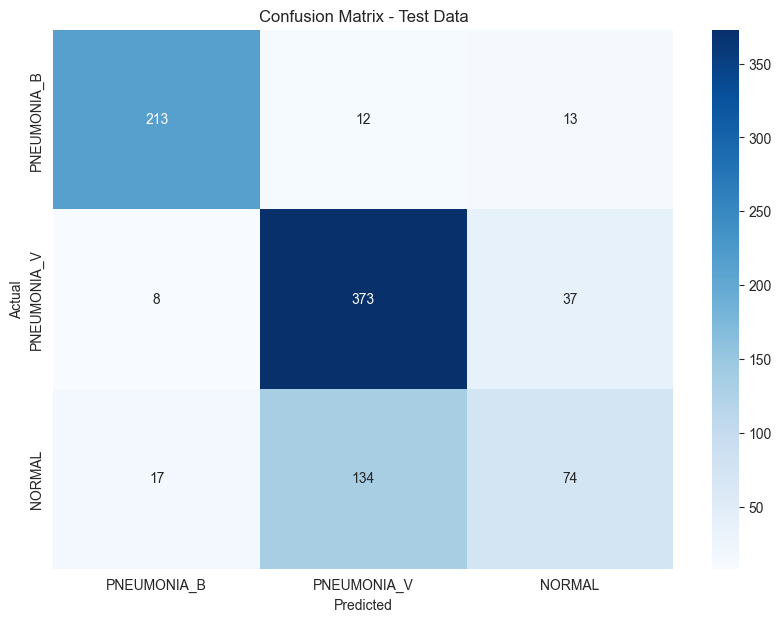

In [15]:
# Evaluation du modèle
y_pred_test = final_model.predict(x_test_pca)
y_pred_val = final_model.predict(x_val_pca)

print("Validation Classification Report:\n", classification_report(y_val, y_pred_val, target_names=labels))
print("Test Classification Report:\n", classification_report(y_test, y_pred_test, target_names=labels))

f1 = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Plot ROC curve
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(x_test_pca)
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_proba[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i, color in zip(range(len(labels)), ['blue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Confusion matrix pour les données de test
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Results without PCA:
Model training completed successfully.

Validation Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.87      0.90      0.89       237
 PNEUMONIA_V       0.74      0.73      0.73       417
      NORMAL       0.50      0.50      0.50       223

    accuracy                           0.71       877
   macro avg       0.70      0.71      0.71       877
weighted avg       0.71      0.71      0.71       877

Test Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.89      0.91      0.90       238
 PNEUMONIA_V       0.74      0.75      0.74       418
      NORMAL       0.49      0.46      0.47       225

    accuracy                           0.72       881
   macro avg       0.71      0.71      0.71       881
weighted avg       0.72      0.72      0.72       881

F1 Score: 0.72


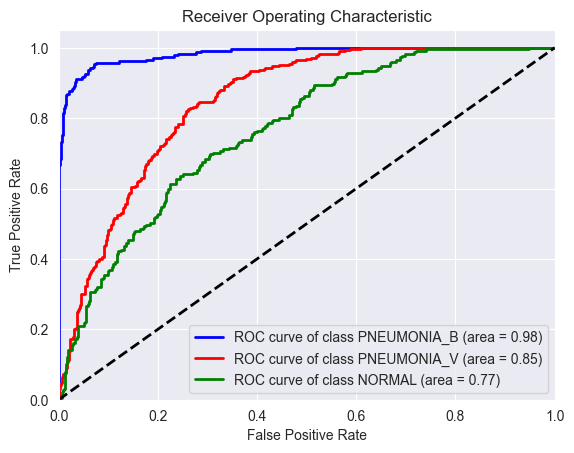

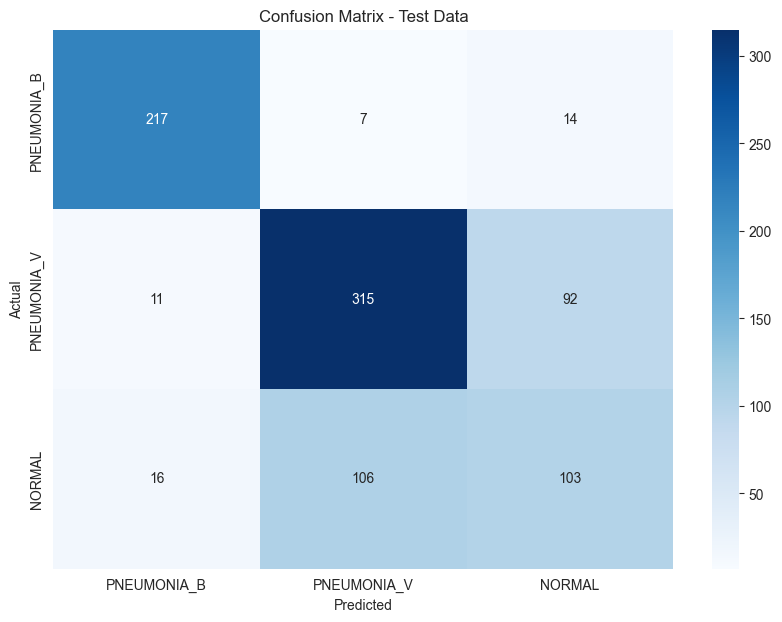

SVC(kernel='linear', probability=True)

In [16]:
# Pour comparer les resultats de l'entrainement sans application de PCA
svm = SVC(kernel='linear', probability=True)
print("Results without PCA:")
train_evaluate_model(svm, x_train, y_train, x_val, y_val, x_test, y_test,labels)

Results with PCA:
Model training completed successfully.

Validation Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.88      0.90      0.89       238
 PNEUMONIA_V       0.71      0.91      0.80       418
      NORMAL       0.71      0.34      0.46       225

    accuracy                           0.76       881
   macro avg       0.77      0.72      0.72       881
weighted avg       0.76      0.76      0.74       881

Test Classification Report:
               precision    recall  f1-score   support

 PNEUMONIA_B       0.83      0.79      0.81       237
 PNEUMONIA_V       0.69      0.91      0.78       417
      NORMAL       0.68      0.29      0.41       223

    accuracy                           0.72       877
   macro avg       0.73      0.67      0.67       877
weighted avg       0.72      0.72      0.70       877

F1 Score: 0.70


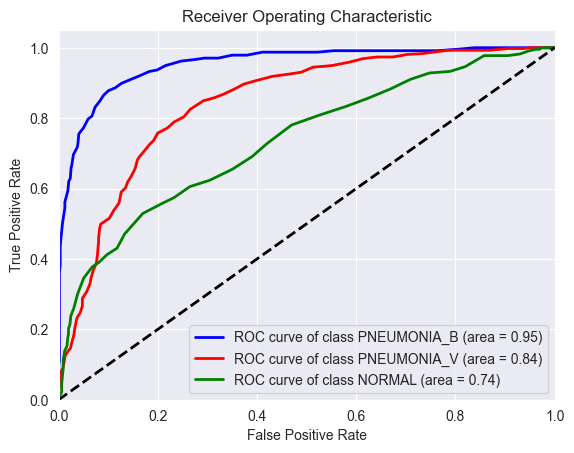

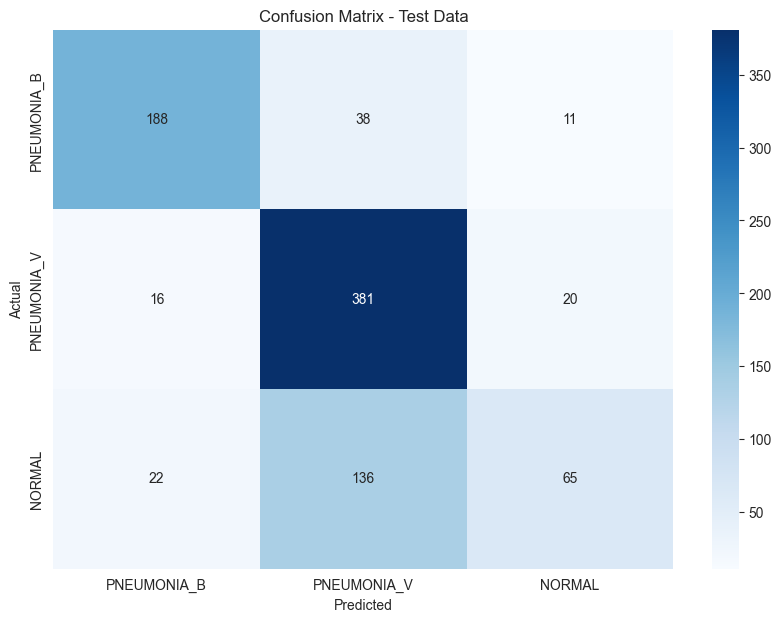

RandomForestClassifier()

In [17]:
# For RandomForestClassifier

rf_model = RandomForestClassifier()
print("Results with PCA:")
train_evaluate_model(rf_model, x_train_pca, y_train, x_test_pca, y_test, x_val_pca, y_val,labels)